**<center>0. ВВЕДЕНИЕ/INTRODUCTION<center>**

Одна из проблем компании [Booking](https://www.booking.com/) — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.

One of the problems of [Booking](https://www.booking.com/) company is the dishonest hotels that twist their ratings. One of the ways to detect such hotels is to build a model that predicts the rating of the hotel. If the model's predictions are very different from the actual result, the hotel may be dishonest and should be checked or looked at more closely.

|column name|description| описание|
|-----------|-----------|---------|
|hotel_address|hotel address|адрес отеля|
|review_date|review date| дата, когда рецензент разместил соответствующий отзыв|
|average_score|average score|средний балл отеля, рассчитанный на основе последнего комментария за последний год|
|hotel_name|hotel name|название отеля|
|reviewer_nationality| reviewer's country|страна рецензента|
|negative_review|negative review|отрицательный отзыв, который рецензент дал отелю|
|review_total_negative_word_counts|total number of words in a negative review|общее количество слов в отрицательном отзыв|
|positive_review|positive review|положительный отзыв, который рецензент дал отел|
|review_total_positive_word_counts|total number of words in a positive review |общее количество слов в положительном отзыве|
|reviewer_score| review score based on review's experience|оценка, которую рецензент поставил отелю на основе своего опыта|
|total_number_of_reviews_reviewer_has_given|total number of reviews given by reviewer|количество отзывов, которые рецензенты дали в прошлом|
|total_number_of_reviews|total number of hotel's reviews|общее количество действительных отзывов об отеле|
|tags|tags given to a hotel by review|теги, которые рецензент дал отелю|
|days_since_review|a difference in the number of days between review date and scrape date|количество дней между датой проверки и датой очистки|
|additional_number_of_scoring| score without review|есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки|
|lat|hotel's latitude|географическая широта отеля|
|lng|hotel's longitude|географическая долгота отеля|

**<center>1. Импорт библиотек и данных / Import libraries and data <center>**

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
import plotly.express as px

# импорт для работы с кодировщиком
import category_encoders as ce

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
# Подгрузим наши данные из соревнования/ Loading our data from Kaggle competition

DATA_DIR = '/kaggle/input/sf-booking/'
df_train = pd.read_csv('Data/hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('Data/hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('Data/submission.csv') # сабмишн

**1.1. Initial data analysis in the train set/Первичный анализ данных в тренировочном датасете**

Проведем первичный анализ данных тренировочного датасета, чтобы выявить признаки, влияющие на рейтинг отеля.

Perform initial data analysis of the training dataset in order to identify features affect reviewer's score.

In [7]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [4]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [8]:
# проверка наличия дубликатов/check of duplicates
mask = df_train.duplicated() # маска для фильтрации дубликатов / mask for filtration
hotels_duplicates = df_train[mask] # фильтраця / filtration
print(f'Number of duplicates in train set:{hotels_duplicates.shape[0]}')

Number of duplicates in train set:307


**Outliners analysis for the numeric data/Анализ выбросов числовых признаков**

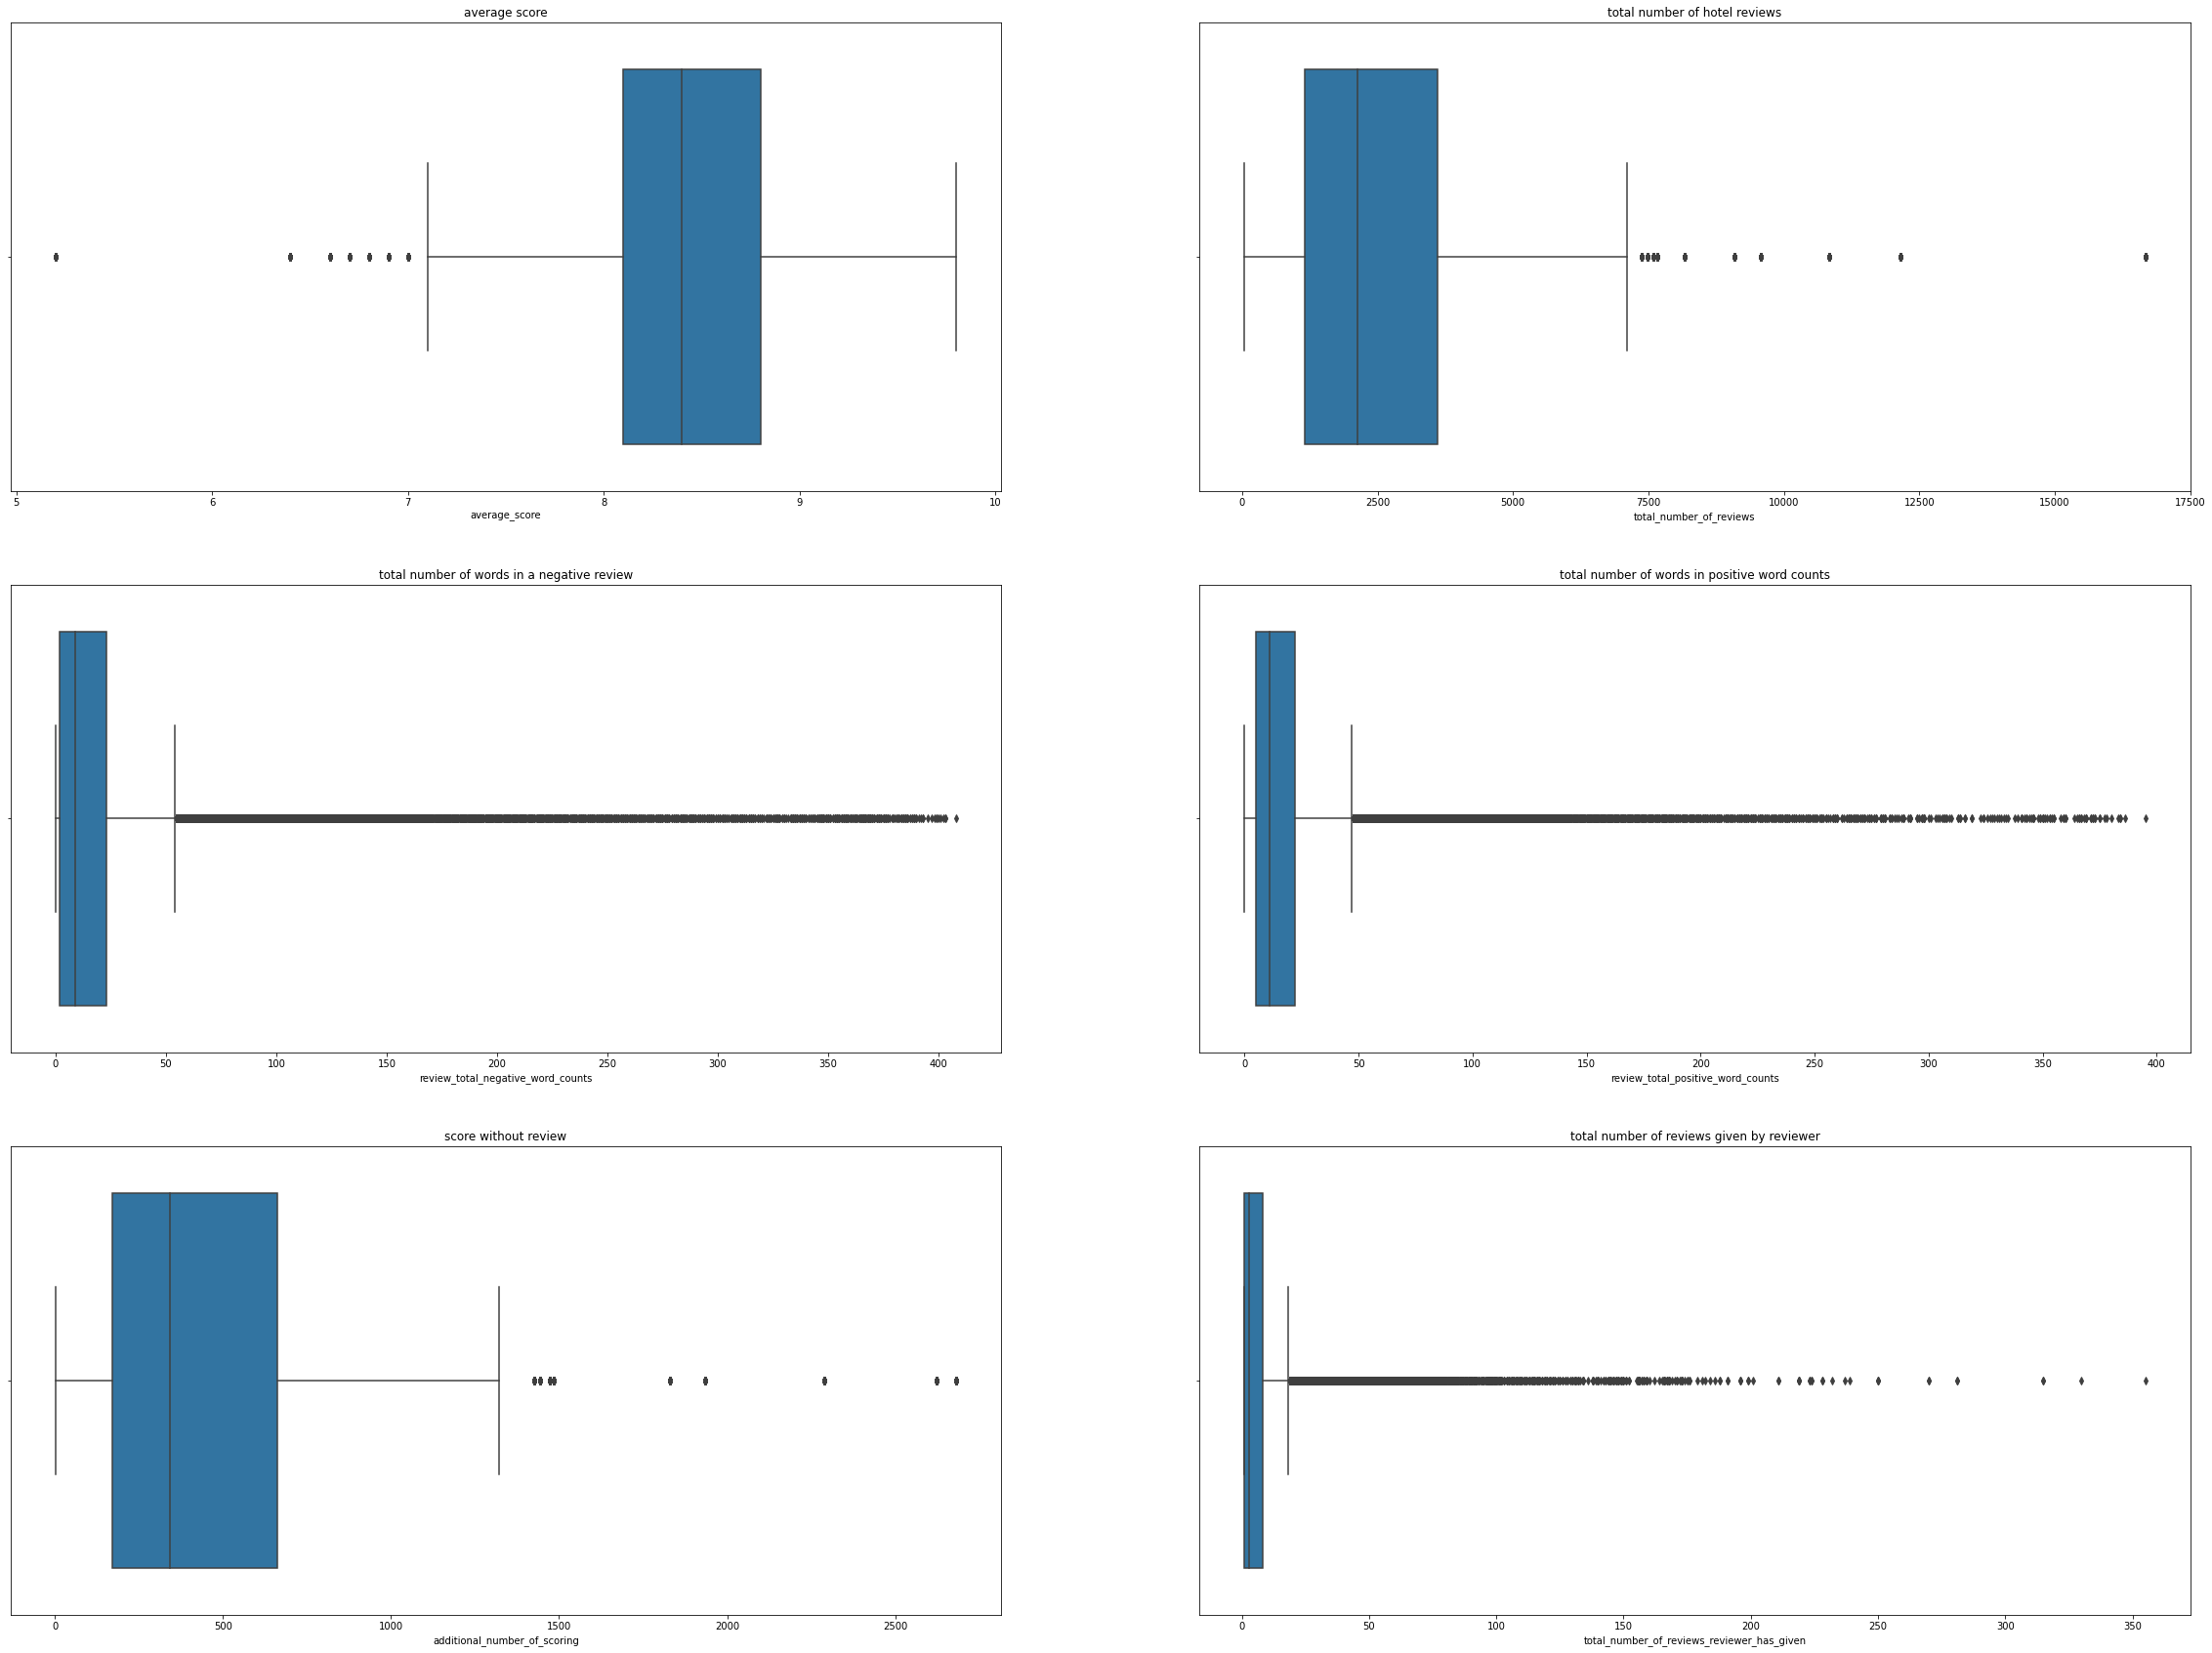

In [6]:
# построение графиков для анализа числовых выбросов 
# creating box plots to visualize outliers of numeric features 
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(40, 30))

boxplot = sns.boxplot(
    data=df_train, 
    x='average_score', 
    ax=axes[0,0]);
boxplot.set_title('average score');

boxplot = sns.boxplot(
    data=df_train, 
    x='total_number_of_reviews', 
    ax=axes[0,1]);
boxplot.set_title('total number of hotel reviews');

boxplot = sns.boxplot(
    data=df_train, 
    x='review_total_negative_word_counts', 
    ax=axes[1,0]);
boxplot.set_title('total number of words in a negative review');

boxplot = sns.boxplot(
    data=df_train, 
    x='review_total_positive_word_counts', 
    ax=axes[1,1]);
boxplot.set_title('total number of words in positive word counts');

boxplot = sns.boxplot(
    data=df_train, 
    x='additional_number_of_scoring', 
    ax=axes[2,0]);
boxplot.set_title('score without review');

boxplot = sns.boxplot(
    data=df_train, 
    x='total_number_of_reviews_reviewer_has_given', 
    ax=axes[2,1]);
boxplot.set_title('total number of reviews given by reviewer');


Выводы по предварительному анализу тренировочного датасета:
1. Количество дубликатов:  307
2. Количество отзывов по отелю, аномальным количеством отзывов считаем количество более 10 000.
3. Количество отзывов одного рецензента, аномальным количестовом считаем более 250.
4. Значения в столбцах количества слов в положительных и отрицательных отзывов вполне адекватны, также как значения среднего значения рейтинга и рейтинга без дополнительных комментариев.

Summary on the initial analysis:
1. Number of duplicates: 307
2. "Total number of hotel's reviews" more than 10,000 is seemed to be abnormal.
3. "Total number of reviews reviewer has given" more than 250 is seemed to be abnormal.
4. The values in the word count columns in positive and negative reviews seems to be quite adequate, as well as values of the average score and rating without additional comments.

In [9]:
# для дальнейшего анализа удалим дубликаты и аномальные значения.
# deleation of duplicates and outliners in the train set
df_train = df_train.drop_duplicates()
df_train = df_train[df_train['total_number_of_reviews_reviewer_has_given'] < 250]
df_train = df_train[df_train['total_number_of_reviews'] < 10000]
print(f'Result number in train set: {df_train.shape[0]}')

Result number in train set: 381135


**1.2. Analysis of the features that affect reviewer's score/Дополнительный анализ признаков, влияющих на рейтинг отеля**

Рассмотрим страну отеля и страну гостя, оставившего отзыв. Оценим влияние этих признаков на выставленный регйтинг. 

Consider the hotel's country of and the reviewer's country, and evaluate their affect on the reviewer's score.

In [10]:
# Функция извлечения страны из адреса отеля/Function for country extraction from the hotel's address

def get_country(hotel_address):
  country = hotel_address.split()[-1]
  if country == 'Kingdom':
    country = 'United Kingdom'
  return country

# извлечем название страны из признака 'hotel_address'/ take country from 'hotel_address'
df_train['country'] = df_train['hotel_address'].apply(get_country)
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,country
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,United Kingdom


In [11]:
# функция извлечения название города из адреса/function for city extraction from the hotel's address
def get_city(hotel_address):
  city = hotel_address.split()[-2]
  if city == 'United':
    city = hotel_address.split()[-5]
  return city

# извлечем название города из признака 'hotel_address'/ take city from 'hotel_address'
df_train['city'] = df_train['hotel_address'].apply(get_city)
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,country,city
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom,London
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,United Kingdom,London


In [10]:
# функция извлечения название города из адреса/function for city extraction from the hotel's address
def get_city(hotel_address):
  city = hotel_address.split()[-2]
  if city == 'United':
    city = hotel_address.split()[-5]
  return city

# извлечем название города из признака 'hotel_address'/ take city from 'hotel_address'
df_train['city'] = df_train['hotel_address'].apply(get_city)
df_train.head(2)

United Kingdom    193673
Spain              45132
France             44527
Netherlands        43001
Austria            29176
Italy              25626
Name: country, dtype: int64

In [11]:
df_train['city'].value_counts()

London       193673
Barcelona     45132
Paris         44527
Amsterdam     43001
Vienna        29176
Milan         25626
Name: city, dtype: int64

В нашем датасете представлены отели из 6 стран: Великобритания, Испания, Франция, Нидерланды, Австрия, 
Италия и 6 городов, т.е. по одному городу из каждой страны, даже без дополнительного анализа можно сказать, 
что признаки страна и город имеют высокую корреляцию, соотвественно, оставляем только 1 признак - страна, 
признак город удаляем.

Our dataset includes hotels from 6 countries: Great Britain, Spain, France, the Netherlands, Austria,
Italy and 6 cities, i.e. one city from each country, even without additional analysis it could be said that
the features 'country' and 'city' have a high correlation, respectively, we leave only 1 – country.

In [12]:
# рассмотрим страну ревьюера/look at reviewer's nationality
df_train['reviewer_nationality'].value_counts().head(30)

 United Kingdom               181706
 United States of America      26200
 Australia                     16023
 Ireland                       10997
 United Arab Emirates           7496
 Saudi Arabia                   6605
 Netherlands                    6523
 Switzerland                    6348
 Canada                         5920
 Germany                        5823
 France                         5464
 Israel                         4842
 Belgium                        4465
 Italy                          4450
 Turkey                         4039
 Kuwait                         3663
 Spain                          3495
 Romania                        3304
 Russia                         2909
 South Africa                   2858
 China                          2533
 Sweden                         2533
 India                          2527
 Greece                         2457
 New Zealand                    2413
 Singapore                      2296
 Hong Kong                      2235
 

Для анализа зависимости оценок отеля от страны ревьюера, выделим 15 стран реьюеров с наибольшим количеством отзывов, остальные отнесем к прочим, кроме Испании (т.к. она списке стран отелей).

To analyze correlation reviewer's score and the reviewer's country we determine 15 reviewer's countries with the largest number of reviewers, the rest will be considered as Others, except Spain (as it is in the list of hotel's countries).

In [12]:
# функция по обработке страны ревьюера/ function for reviewer's nationality processing 

def get_residenship(reviewer_nationality):
      
    if 'United Kingdom' in reviewer_nationality:
        return 'United Kingdom'
    elif 'United States of America' in reviewer_nationality:
        return 'United States of America'
    elif 'Australia' in reviewer_nationality:
        return 'Australia'
    elif 'Ireland' in reviewer_nationality:
        return 'Ireland'
    elif 'United Arab Emirates' in reviewer_nationality:
        return 'United Arab Emirates'
    elif 'Saudi Arabia' in reviewer_nationality:
        return 'Saudi Arabia'
    elif 'Netherlands' in reviewer_nationality:
        return 'Netherlands'
    elif 'Switzerland' in reviewer_nationality:
        return 'Switzerland'
    elif 'Canada' in reviewer_nationality:
        return 'Canada'
    elif 'Germany' in reviewer_nationality:
        return 'Germany'
    elif 'France' in reviewer_nationality:
        return 'France'
    elif 'Israel' in reviewer_nationality:
        return 'Israel'
    elif 'Italy' in reviewer_nationality:
        return 'Italy'
    elif 'Turkey' in reviewer_nationality:
        return 'Turkey'
    elif 'Spain' in reviewer_nationality:
        return 'Spain'
    elif 'Austria' in reviewer_nationality:
        return 'Austria'
    else:
        return 'Other'

df_train['reviewer_nationality'] = df_train['reviewer_nationality'].apply(get_residenship)

In [13]:
# сравним страну отеля со страной ревьюера/ compare the hotel's country and reviewer's nationality
df_train['residence'] = df_train.apply(lambda x: 'local' if x['reviewer_nationality'] == x['country'] else 'foreigner', axis = 1)
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng,country,city,residence
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671,United Kingdom,London,local
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097,United Kingdom,London,local


In [17]:
# Сгруппируем данные по странам и проверим есть ли отличия в оценках местных посетителей и иностранцев.
# Group the data by country and check if there are any differences in the reviewer's score from local visitors and foreigners.

data_citizen = df_train.groupby(['country', 'residence'], as_index=False)['reviewer_score'].median()

fig = px.bar(
    data_citizen,
    x='reviewer_score',
    y='country',
    color='residence',
    barmode='group',
    width=900,
    title='Reviewier score based on the residenship of hotel country')
fig.show()

In [18]:
# рассмотрим влияет ли страна ревьюера на его отзыв/consider the correlation 'reviewer_nationality' on its score
#группируем данные по признаку страны ревьера/group by 'reviewer_nationality'

data_nationality = df_train.groupby(['reviewer_nationality', 'residence'], as_index=False)['reviewer_score'].median()

fig = px.bar(
    data_nationality,
    x='reviewer_score',
    y='reviewer_nationality',
    color='residence',
    barmode='group',
    width=900,
    height=700,
    title='Reviewier score on the reviewer residence')
fig.show()

Рассмотрим влияние сезона на отзывы посетителей, предположим, что посетители оставляли отзывы сразу после посещения.

Look at the correlation reviewer's score with the season of visitor's review. We assume that visitors leave reviews after visiting immediately.

In [14]:
# приведение признака 'review_date' к типу date/transforming feature 'review_date' to date type
df_train['review_date'] = pd.to_datetime(df_train['review_date'], format='%m/%d/%Y')

# создание признака сезон/make new feature - season 
df_train['season_review'] = df_train['review_date'].dt.month

# функция по определению сезона / function for season defenition
def get_season(month):
        
    if month in list(range(3,6)):
        return 2 #'spring'
    
    if month in list(range(6,9)):
        return 3 #'summer'
    
    if month in list(range(9,12)):
        return 4 #'autumn'
    
    else:
        return 1 #'winter'

df_train['season_review'] = df_train['season_review'].apply(get_season)

In [20]:
#рассмотрим влияет ли сезон на отзыв/consider the correlation 'season' on reviewer's score
#группируем данные по признаку сезона/group by 'season'

data_season = df_train.groupby(['country', 'season_review'], as_index=False)['reviewer_score'].median()

fig = px.bar(
    data_season,
    x='country',
    y='reviewer_score',
    color='season_review',
    barmode='group',
    width=900,
    title='Reviewier_score on season')
fig.show()

По результатам предварительного анализа обратили внимание:
1. Путешественники из Северной Америки (США, Канада), Австралии и Израиля ставят более высокие оценки отелям. 
2. Французские и испанские путешественники ставят более высокие оценки своим местным отелям, чем иностранным, тогда как жители Нидерландов, Австрии и Италии ставят примерно одинаковые оценки местным и иностранным, а жители Великобритании более критичны к своим местным отелям, чем к иностранным.
3. Что в странах, обладающих инфраструктурой для сезонного отдыха (лето (морской отдых), зима-весна (горнолыжный)), оценки выше в соответствующий сезон, при отсутствии сезонной инфраструктуры средняя оценка – примерно одинаковая в течение всего года. Соответственно, можно предположить, что человек, находящийся на отдыхе, ставит более высокие оценки, т.к. на отдыхе человек, в основном, настроен положительно.

Учтем данную информацию, при проектировании признаков и анализе других признаков. 

Based on the results of the initial analysis noted that:
1. Travelers from North America (USA, Canada), Australia and Israel rate hotels higher.
2. French and Spanish travellers rate their local hotels higher than foreign ones, while residents of Netherlands, Austria and Italy rate local and foreign hotels at the same level, and the UK residents are more critical of their local hotels than foreign ones.
3. The countries with the infrastructure for seasonal recreation (summer (sea vacation), winter-spring (skiing)), have higher ratings in the appropriate season. In case the country has no special seasonal infrastructure, the average rating is approximately at the same level all the year round. So, it can be assumed that a person who is on vacation usually gives higher marks, because people are more positive on vacations in general.

We will consider this information when designing features and analyzing the other ones.

**1.3. Joining train and test sets NON NULL data/ Объединение обучаемого (train) и тестируемого (test) датасетов, анализ пропусков.**

In [15]:
# Еще раз прочитаем данные/ Reading our data again

df_train = pd.read_csv('Data/hotels_train.csv') # датасет для обучения/ train data
df_test = pd.read_csv('Data/hotels_test.csv') # датасет для предсказания/ test data
sample_submission = pd.read_csv('Data/submission.csv') # сабмишн/ submission

**Фиксация / Fixing**

In [22]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [17]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
# fixing packages version

!pip freeze > requirements.txt

In [18]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
#  RANDOM_SEED fixing
RANDOM_SEED = 42

In [19]:
# Перед объединением из тренировочного датасета удалим дубликаты и выбросы, выявленные ранее/
# Remove duplicates and outliers identified earlier from the train data before merging 

mask = df_train.duplicated() # маска для фильтрации дубликатов / filtration mask
hotels_duplicates = df_train[mask] # фильтраця / filtration

df_train = df_train.drop_duplicates()
df_train = df_train[df_train['total_number_of_reviews_reviewer_has_given'] < 250]
df_train = df_train[df_train['total_number_of_reviews'] < 10000]

In [20]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
# To process features correctly, we merge train and test data into one dataset

df_train['sample'] = 1 # помечаем где у нас трейн/ mark for train data
df_test['sample'] = 0 # помечаем где у нас тест/ mark for test data

# в тесте у нас нет значения reviewer_score, мы его должны предсказать, по этому пока просто заполняем нулями
# there is no reviewer_score in test data and we have to predict it, so for now we fill it with zeros
df_test['reviewer_score'] = 0 

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем/merge

data.info()

C:\Users\DOM\AppData\Local\Temp\ipykernel_1096\2627700035.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем/merge


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510070 entries, 0 to 510069
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               510070 non-null  object 
 1   additional_number_of_scoring                510070 non-null  int64  
 2   review_date                                 510070 non-null  object 
 3   average_score                               510070 non-null  float64
 4   hotel_name                                  510070 non-null  object 
 5   reviewer_nationality                        510070 non-null  object 
 6   negative_review                             510070 non-null  object 
 7   review_total_negative_word_counts           510070 non-null  int64  
 8   total_number_of_reviews                     510070 non-null  int64  
 9   positive_review                             510070 non-null  object 
 

In [27]:
# Проверка нулевых значений в объединенном датасете / Checking for Null Values in merged dataset
data.isnull().sum()

hotel_address                                    0
additional_number_of_scoring                     0
review_date                                      0
average_score                                    0
hotel_name                                       0
reviewer_nationality                             0
negative_review                                  0
review_total_negative_word_counts                0
total_number_of_reviews                          0
positive_review                                  0
review_total_positive_word_counts                0
total_number_of_reviews_reviewer_has_given       0
tags                                             0
days_since_review                                0
lat                                           3268
lng                                           3268
sample                                           0
reviewer_score                                   0
dtype: int64

Есть пропуски в 2 столбцах: lat (широта) и lng (долгота), пока заполним "0", возможно, для дальнейшего анализа потребуется произвести замену.  

Null values are in 2 columns: lat (latitude) and lng (longitude), while we fill in "0", it may be necessary to make a replacement for further analysis.

In [21]:
# Замена пропусков на 0 / Null values replacement for 0 

data['lat'] = data['lat'].fillna(0, inplace=False)
data['lng'] = data['lng'].fillna(0, inplace=False)

In [29]:
# Количество уникальных значений / Number of unique values
data.nunique(dropna=False)

hotel_address                                   1493
additional_number_of_scoring                     480
review_date                                      731
average_score                                     34
hotel_name                                      1492
reviewer_nationality                             226
negative_review                               326390
review_total_negative_word_counts                402
total_number_of_reviews                         1142
positive_review                               408357
review_total_positive_word_counts                364
total_number_of_reviews_reviewer_has_given       192
tags                                           54932
days_since_review                                731
lat                                             1473
lng                                             1473
sample                                             2
reviewer_score                                    38
dtype: int64

<AxesSubplot: >

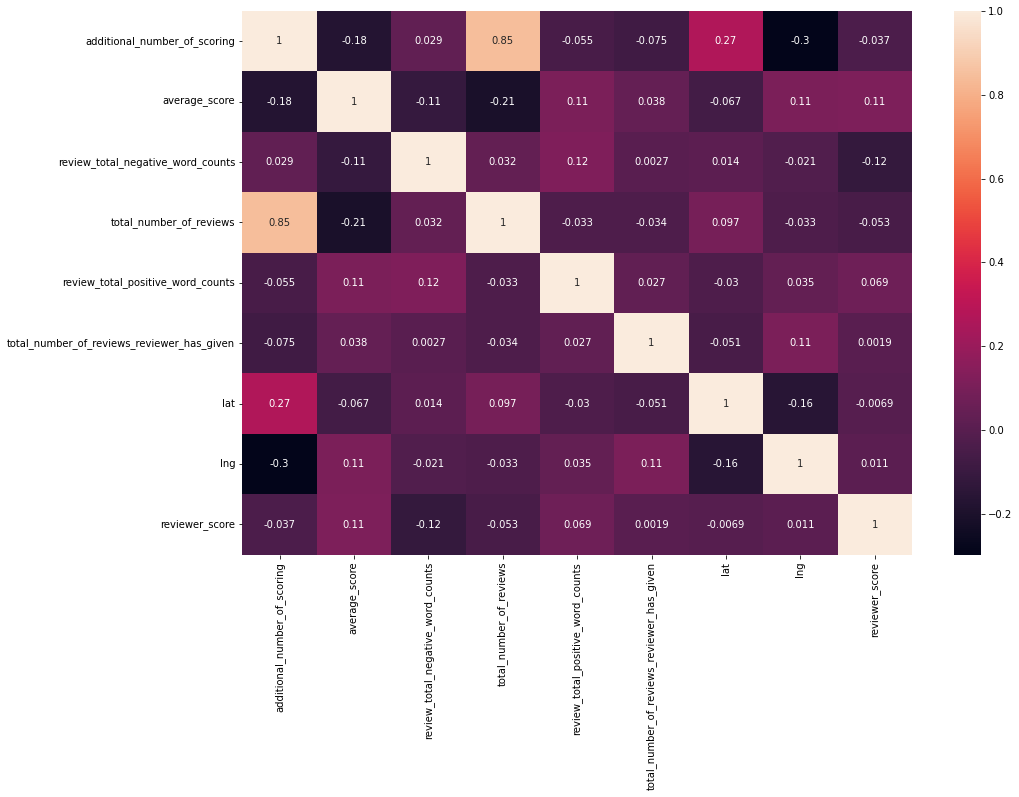

In [30]:
# Проверим корреляцию числовых признаков / Сheck the correlation of numerical features

plt.rcParams['figure.figsize'] = (15,10)
sns.heatmap(data.drop(['sample'], axis=1).corr(), annot=True)

В соответвии с данными тепловой матрицы корреляции Спирмена наблюдаем прямую коррекляцию между количеством отзывов об отеле и количеством оценок без отзывов. 
Дополнительно, проверим наше предположение на графике попарной коррекляции.

In accordance with the data of Spearman's correlation heatmap, there is a direct correlation between the 'total number of reviews' and 'additional number of scoring'.
Additionally, it's better to check our assumption on the pairplot correction chart.

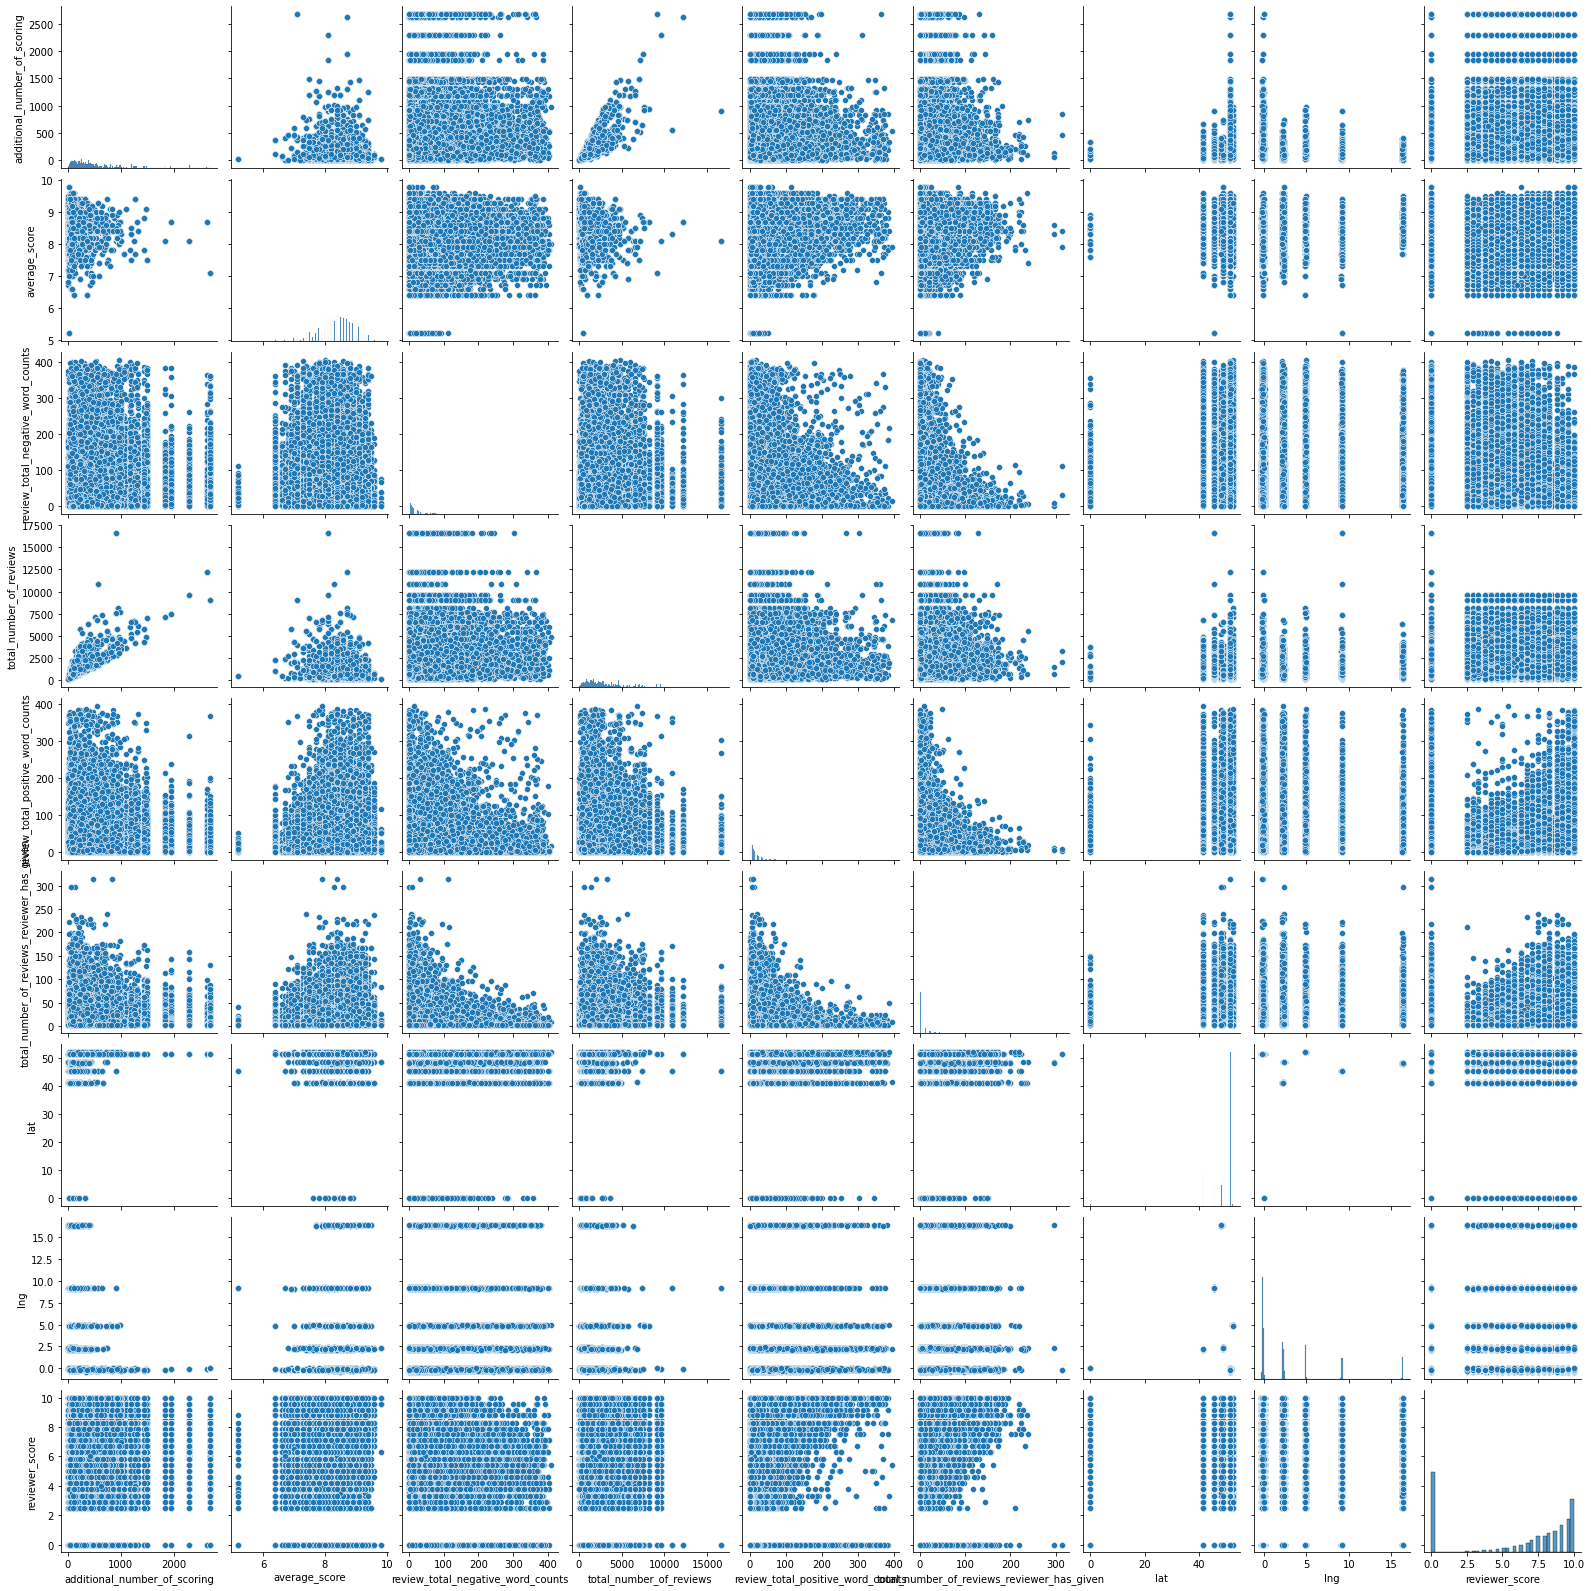

In [31]:
sns.pairplot(data.drop(['sample'], axis=1))

В соответвии с данными графиков попарной корреляции наше предположение о прямой коррекляции между количеством отзывов об отеле и количеством оценок без отзывов подтвердилось. 
На данном этапе оставляем оба признака, возможно, какой-либо признак потребуется при обучении модели. 

In accordance with pairplot correction chart, our assumption on direct correlation between the 'total number of reviews' and 'additional number of scoring' was confirmed. 
At this stage, we leave both features, perhaps will need some while training the model.

**2. Проектирование и обработка нечисловых признаков/ Design and processing of non-numeric features**

**2.1. Адрес отеля/ Hotel's adress**

In [32]:
# Рассмотрим признак "адрес отеля"/ Look at the 'hotel_adress'
data['hotel_address'][115]

'Cardenal Reig 11 Les Corts 08028 Barcelona Spain'

Из адреса можно выделить 2 новых признака: страна и город, т.к. все страны представлены только одним городом, выделим только страну, т.к. потом ее можно будет сравнить со страной рецензента. 

We can get 2 new features from hotel's address: country and city, as all countries are represented by only one city, we create only the country, because further it could be compared with reviewer's nationality/country.

In [22]:
# Применим функцию get_country, описанную выше. 
# Applying function get_country, defined above

data['country'] = data['hotel_address'].apply(get_country)
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng,sample,reviewer_score,country
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102,0,0.0,Italy
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443,0,0.0,Netherlands


In [23]:
# Закодируем признак 'country'/ Encode the feature 'country'
encoder = ce.OneHotEncoder(cols=['country'], use_cat_names=True) # указываем столбец для кодирования/ specifying the column to encode
type_bin = encoder.fit_transform(data['country'])
data = pd.concat([data, type_bin], axis=1)
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,lng,sample,reviewer_score,country,country_Italy,country_Netherlands,country_Spain,country_United Kingdom,country_France,country_Austria
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,9.171102,0,0.0,Italy,1,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,...,4.834443,0,0.0,Netherlands,0,1,0,0,0,0


**2.2. Страна ревьюера/ Reviewer's nationality**

In [24]:
# Обработка признака / Process feature
data['reviewer_nationality'] = data['reviewer_nationality'].apply(get_residenship)

# Кодировка признака/Encode the feature 
encoder = ce.OneHotEncoder(cols=['reviewer_nationality'], use_cat_names=True) # указываем столбец для кодирования/ specifying the column to encode
type_bin = encoder.fit_transform(data['reviewer_nationality'])
data = pd.concat([data, type_bin], axis=1)
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_Australia,reviewer_nationality_Saudi Arabia,reviewer_nationality_France,reviewer_nationality_Germany,reviewer_nationality_United Arab Emirates,reviewer_nationality_Spain,reviewer_nationality_Switzerland,reviewer_nationality_Turkey,reviewer_nationality_Israel,reviewer_nationality_Austria
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,0,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Other,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# Создание признака residence: если ревьюер местный - 1, если иностранец - О
# Create feature residence: local reviewer - 1, foreigner - 0
data['residence'] = data.apply(lambda x: 1 if x['reviewer_nationality'] == x['country'] else 0, axis = 1)
data.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,...,reviewer_nationality_Saudi Arabia,reviewer_nationality_France,reviewer_nationality_Germany,reviewer_nationality_United Arab Emirates,reviewer_nationality_Spain,reviewer_nationality_Switzerland,reviewer_nationality_Turkey,reviewer_nationality_Israel,reviewer_nationality_Austria,residence
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,...,0,0,0,0,0,0,0,0,0,0
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Other,No tissue paper box was present at the room,10,5018,No Positive,...,0,0,0,0,0,0,0,0,0,0


In [26]:
# Удаление закодированных признаков/ Deleate encoded features
data = data.drop(['country', 'reviewer_nationality'], axis=1)

# Удаление лишних признаков/ Dealete redundant features
data = data.drop(['hotel_address', 'lat', 'lng'], axis=1)

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510070 entries, 0 to 510069
Data columns (total 38 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   additional_number_of_scoring                   510070 non-null  int64  
 1   review_date                                    510070 non-null  object 
 2   average_score                                  510070 non-null  float64
 3   hotel_name                                     510070 non-null  object 
 4   negative_review                                510070 non-null  object 
 5   review_total_negative_word_counts              510070 non-null  int64  
 6   total_number_of_reviews                        510070 non-null  int64  
 7   positive_review                                510070 non-null  object 
 8   review_total_positive_word_counts              510070 non-null  int64  
 9   total_number_of_reviews_reviewer_has_

**2.3. Дата отзыва/ Review date**

In [27]:
# Изменение типа данных признака 
# Change date's type from object to dtype for review_date

data['review_date'] = pd.to_datetime(data['review_date'], format='%m/%d/%Y')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510070 entries, 0 to 510069
Data columns (total 38 columns):
 #   Column                                         Non-Null Count   Dtype         
---  ------                                         --------------   -----         
 0   additional_number_of_scoring                   510070 non-null  int64         
 1   review_date                                    510070 non-null  datetime64[ns]
 2   average_score                                  510070 non-null  float64       
 3   hotel_name                                     510070 non-null  object        
 4   negative_review                                510070 non-null  object        
 5   review_total_negative_word_counts              510070 non-null  int64         
 6   total_number_of_reviews                        510070 non-null  int64         
 7   positive_review                                510070 non-null  object        
 8   review_total_positive_word_counts           

In [28]:
# Создание признака сезон/Create a new feature - season 
data['season'] = data['review_date'].dt.month

# Применим функцию по определению сезона/ Apply season defining function
data['season'] = data['season'].apply(get_season)
data.head(2)

,additional_number_of_scoring,review_date,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,...,reviewer_nationality_France,reviewer_nationality_Germany,reviewer_nationality_United Arab Emirates,reviewer_nationality_Spain,reviewer_nationality_Switzerland,reviewer_nationality_Turkey,reviewer_nationality_Israel,reviewer_nationality_Austria,residence,season
0,904,2017-07-21,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,...,0,0,0,0,0,0,0,0,0,3
1,612,2016-12-12,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,No Positive,0,7,...,0,0,0,0,0,0,0,0,0,1


In [29]:
# Удаление закодированного признка/ Dealete encoded feature
data.drop('review_date', axis = 1, inplace=True) 
data.head(2)

,additional_number_of_scoring,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,...,reviewer_nationality_France,reviewer_nationality_Germany,reviewer_nationality_United Arab Emirates,reviewer_nationality_Spain,reviewer_nationality_Switzerland,reviewer_nationality_Turkey,reviewer_nationality_Israel,reviewer_nationality_Austria,residence,season
0,904,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",...,0,0,0,0,0,0,0,0,0,3
1,612,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",...,0,0,0,0,0,0,0,0,0,1


**2.4. Tэги. Изучение и преобразование./ Tags. Study and transformation.**

In [42]:
# Изучение/Study
data['tags']

0         [' Leisure trip ', ' Couple ', ' Double Room '...
1         [' Leisure trip ', ' Group ', ' Triple Room ',...
2         [' Business trip ', ' Solo traveler ', ' Twin ...
3         [' Leisure trip ', ' Couple ', ' Ambassador Ju...
4         [' Business trip ', ' Solo traveler ', ' Class...
                                ...                        
510065    [' Leisure trip ', ' Group ', ' Club Double or...
510066    [' Leisure trip ', ' Couple ', ' Standard Doub...
510067    [' Business trip ', ' Solo traveler ', ' Singl...
510068    [' Leisure trip ', ' Solo traveler ', ' Deluxe...
510069    [' Leisure trip ', ' Couple ', ' Bunk Bed Room...
Name: tags, Length: 510070, dtype: object

In [30]:
# Функция по очистке признака от лишних символов/ Function to clean the feature from the redundant elements

def rev_func(num_tags):
    num_tags = num_tags[2:-2]
    res = num_tags.strip().split(' \', \' ')
    return res

data['tags'] = data['tags'].apply(rev_func)

In [44]:
data['tags']

0         [Leisure trip, Couple, Double Room, Stayed 2 n...
1         [Leisure trip, Group, Triple Room, Stayed 1 ni...
2         [Business trip, Solo traveler, Twin Room, Stay...
3         [Leisure trip, Couple, Ambassador Junior Suite...
4         [Business trip, Solo traveler, Classic Double ...
                                ...                        
510065    [Leisure trip, Group, Club Double or Twin Room...
510066    [Leisure trip, Couple, Standard Double Room, S...
510067    [Business trip, Solo traveler, Single Room, St...
510068    [Leisure trip, Solo traveler, Deluxe Double Ro...
510069    [Leisure trip, Couple, Bunk Bed Room, Stayed 4...
Name: tags, Length: 510070, dtype: object

In [31]:
# Создаим список тегов/Create a list of tags
tags_list = []
for tags in data['tags']:
    tags_list.extend(tags)

# С помощью модуля Collections посчитаем наиболее часто встречающиеся тэги.
# Count the most common tags with Collections module.

# Ипорт Counte/Import Counter
from collections import Counter

# Посчитаем тэги, выведем 30 наиболе часто встречающихся/Count the tags, display the 30 most common
tags_counter = Counter(tags_list)
tags_counter.most_common(30)

[('Leisure trip', 413008),
 ('Submitted from a mobile device', 304296),
 ('Couple', 249864),
 ('Stayed 1 night', 191381),
 ('Stayed 2 nights', 132381),
 ('Solo traveler', 107782),
 ('Stayed 3 nights', 94856),
 ('Business trip', 82217),
 ('Group', 64667),
 ('Family with young children', 59714),
 ('Stayed 4 nights', 47378),
 ('Double Room', 33754),
 ('Standard Double Room', 32246),
 ('Superior Double Room', 30975),
 ('Family with older children', 25928),
 ('Deluxe Double Room', 24811),
 ('Double or Twin Room', 22393),
 ('Stayed 5 nights', 20638),
 ('Standard Double or Twin Room', 17477),
 ('Classic Double Room', 16877),
 ('Superior Double or Twin Room', 13570),
 ('2 rooms', 12170),
 ('Standard Twin Room', 9745),
 ('Stayed 6 nights', 9681),
 ('Single Room', 9668),
 ('Twin Room', 8138),
 ('Stayed 7 nights', 7329),
 ('Executive Double Room', 6425),
 ('Classic Double or Twin Room', 6100),
 ('Superior Twin Room', 6054)]

По итогам подсчета, наиболее популярных тэгов, наши предположения подтвердились: 
1.	Большинство ревьюеров находись на отдыхе (Leisure trip – наиболее частный тэг).
2.	Отзывы оставлялись достаточно оперативно (Submitted from a mobile device – второй по популярности тэг).

Создадим дополнительные признаки из наиболее популярных тэгов:
1. Цель поездки:
+ leisure_trip – отдых;
+ business_trip – командировка.
2. Продолжительность пребывания:
+ one_night – 1 ночь;
+ two_nights – 2 ночи;
+ three_nights – 3 ночи.
3. Количество гостей:
+ solo – один; 
+ couple – два; 
+ group – несколько;
+ with children – гости с детьми.
4. mobile_review – отзыв по с мобильного.

Based on the results of the calculation of the most popular tags, our assumptions were confirmed:
1. Most reviewers are made on vacation (Leisure trip is the most common tag).
2. Reviews were left fairly quickly (Submitted from a mobile device is the second most popular tag).

Create additional features basing on the most common tags:
+ Trip goal: leisure_trip, business_trip.
+ Staying duration: one_night, two_nights, three_nights.
+ Number of guests: solo (one), couple (two), group (seceral), with_children (guests with children).
+ Mobile_review – review from mobile.

In [32]:
# Цель поездки/Trip goal 
data['leisure_trip'] = data['tags'].apply(lambda x: 1 if 'Leisure trip' in x else 0)
data['business_trip'] = data['tags'].apply(lambda x: 1 if 'Business trip' in x else 0)

In [33]:
# Продолжительность пребывания/ Staying duration
data['one_night'] = data['tags'].apply(lambda x: 1 if 'Stayed 1 night' in x else 0)
data['two_nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 2 nights' in x else 0)
data['three_nights'] = data['tags'].apply(lambda x: 1 if 'Stayed 3 nights' in x else 0) 

In [34]:
# Количество гостей/ Number of quests
data['solo'] = data['tags'].apply(lambda x: 1 if 'Solo traveler' in x else 0)
data['couple'] = data['tags'].apply(lambda x: 1 if 'Couple' in x else 0)
data['group'] = data['tags'].apply(lambda x: 1 if 'Group' in x else 0)
data['with_children'] = data['tags'].apply(lambda x: 1 if ('Family with young children' in x) 
                                                        or ('Family with older children' in x) else 0)

In [35]:
# Отзыв с мобильного/Mobile review
data['mobile_review'] = data['tags'].apply(lambda x: 1 if 'Submitted from a mobile device' in x else 0)

In [36]:
# Удаление закодированного признка/ Dealete encoded feature
data.drop('tags', axis = 1, inplace=True) 
data.head(2)

,additional_number_of_scoring,average_score,hotel_name,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,...,leisure_trip,business_trip,one_night,two_nights,three_nights,solo,couple,group,with_children,mobile_review
0,904,8.1,Hotel Da Vinci,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,13 days,...,1,0,0,1,0,0,1,0,0,0
1,612,8.6,Urban Lodge Hotel,No tissue paper box was present at the room,10,5018,No Positive,0,7,234 day,...,1,0,1,0,0,0,0,1,0,0


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510070 entries, 0 to 510069
Data columns (total 47 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   additional_number_of_scoring                   510070 non-null  int64  
 1   average_score                                  510070 non-null  float64
 2   hotel_name                                     510070 non-null  object 
 3   negative_review                                510070 non-null  object 
 4   review_total_negative_word_counts              510070 non-null  int64  
 5   total_number_of_reviews                        510070 non-null  int64  
 6   positive_review                                510070 non-null  object 
 7   review_total_positive_word_counts              510070 non-null  int64  
 8   total_number_of_reviews_reviewer_has_given     510070 non-null  int64  
 9   days_since_review                    

**2.5. 'Negative_review'. Изучение и преобразование./ 'Negative_review'. Study and transformation.**

In [52]:
# Выведем 50 самых популярных отзывов/Display the 50 most common
data['negative_review'].value_counts().nlargest(50)

No Negative                    126674
 Nothing                        14155
 Nothing                         4193
 nothing                         2204
 N A                             1026
 None                             975
                                  843
 N a                              505
 Breakfast                        397
 Small room                       372
 Location                         358
 Everything                       322
 All good                         314
 Nothing really                   314
 none                             302
 nothing                          280
 No complaints                    272
 Price                            259
 Nothing really                   250
 Nil                              246
 n a                              223
 Nothing at all                   219
 Nothing to dislike               207
 Nothing at all                   192
 Small rooms                      188
 None                             180
 No complain

In [37]:
#Приведем строки к единообразию/Make strings uniform
data['negative_review'] = data['negative_review'].apply(lambda x : x.lower().strip())
#Выведем 30 самых популярных отзывов/Display the 30 most common
data['negative_review'].value_counts().nlargest(30)

no negative                  126674
nothing                       20977
n a                            1794
none                           1490
                                843
nothing really                  648
small room                      567
all good                        539
breakfast                       534
no complaints                   517
location                        485
nothing at all                  461
everything                      414
nothing to dislike              368
price                           344
nil                             331
small rooms                     307
everything was perfect          274
na                              266
can t think of anything         249
leaving                         242
absolutely nothing              241
everything was great            221
nothing to complain about       204
expensive                       203
room size                       200
very small room                 199
no                          

In [38]:
# Некоторые признаки ложно негативные, указано, что нет негативного (no negative, everything was perfect и прочие). 
# Создадим новый признак 'is_negative' с учетом ложно негативных, которые встречаются более 180 раз/
# Some elements are false negative, actually they have no negative (such as no negative, everything was perfect and others). 
# Create a new feature 'is_negative', taking into account false negatives that occur more than 180 times.

false_negative_review = ['no negative', 'nothing', 'n a', 'none', 'nothing really', 'all good', 'no complaints', 
                         'nothing at all', 'nothing to dislike', 'everything was perfect',  'na', 
                         'everything was perfect', 'can t think of anything', 'absolutely nothing', 
                         'everything was great', 'nothing to complain about', 'no', 'nothing all good']

data['is_negative'] = data['negative_review'].apply(lambda x: 0 if x in false_negative_review else 1)

In [39]:
# Удаление закодированного признка/ Dealete encoded feature
data.drop('negative_review', axis = 1, inplace=True) 
data.head(2)

,additional_number_of_scoring,average_score,hotel_name,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,...,business_trip,one_night,two_nights,three_nights,solo,couple,group,with_children,mobile_review,is_negative
0,904,8.1,Hotel Da Vinci,52,16670,Hotel was great clean friendly staff free bre...,62,1,13 days,0,...,0,0,1,0,0,1,0,0,0,1
1,612,8.6,Urban Lodge Hotel,10,5018,No Positive,0,7,234 day,0,...,0,1,0,0,0,0,1,0,0,1


**2.6. 'Positive_review'. Изучение и преобразование./ 'Positive_review'. Study and transformation.**

In [56]:
#Выведем 50 самых популярных отзывов/Display the 50 most common
data['positive_review'].value_counts().nlargest(50)

No Positive                    35529
 Location                       9128
 Everything                     2250
 location                       1662
 Nothing                        1228
 The location                   1120
 Great location                 1032
 Good location                   924
 Location                        904
 Everything                      605
 Breakfast                       601
 Friendly staff                  512
 Staff                           451
 Excellent location              389
 Great location                  369
 Location and staff              332
 everything                      316
 Good location                   275
 Nothing                         221
 Comfy bed                       220
 nothing                         215
 The location                    212
 good location                   203
 The staff                       195
 Good breakfast                  187
                                 182
 the location                    180
 

In [40]:
# Приведем строки к единообразию/Make strings uniform
data['positive_review'] = data['positive_review'].apply(lambda x : x.lower().strip())
# Выведем 50 самых популярных отзывов/Display the 50 most common
data['positive_review'].value_counts().nlargest(50)

no positive                      35529
location                         11822
everything                        3269
nothing                           1710
great location                    1669
the location                      1597
good location                     1489
breakfast                          786
friendly staff                     730
excellent location                 633
staff                              551
location and staff                 451
location staff                     428
location location location         344
location was great                 325
everything was perfect             315
location was good                  312
good breakfast                     312
comfy bed                          301
perfect location                   284
the staff                          277
location is great                  275
location is good                   255
all                                248
clean                              234
every thing              

In [41]:
# Некоторые признаки ложно положительные, указано, что нет положительного (no positive, nothing).
# Создадим новый признак 'is_positive' с учетом ложно положительных, которые встречаются более 180 раз. 
# Some elements are false positive, actually they have no positive (such as no positive, nothing). 
# Create a new feature 'is_ positive', taking into account false positives that occur more than 180 times.

false_positive_review = ['no positive', 'nothing']

# создадим признак того, является ли отзыв положительным
data['is_positive'] = data['positive_review'].apply(lambda x: 0 if x in false_positive_review else 1)

In [42]:
# Удаление закодированного признка/ Dealete encoded feature
data.drop('positive_review', axis = 1, inplace=True) 
data.head(2)

,additional_number_of_scoring,average_score,hotel_name,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,sample,reviewer_score,...,one_night,two_nights,three_nights,solo,couple,group,with_children,mobile_review,is_negative,is_positive
0,904,8.1,Hotel Da Vinci,52,16670,62,1,13 days,0,0.0,...,0,1,0,0,1,0,0,0,1,1
1,612,8.6,Urban Lodge Hotel,10,5018,0,7,234 day,0,0.0,...,1,0,0,0,0,1,0,0,1,0


In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510070 entries, 0 to 510069
Data columns (total 47 columns):
 #   Column                                         Non-Null Count   Dtype  
---  ------                                         --------------   -----  
 0   additional_number_of_scoring                   510070 non-null  int64  
 1   average_score                                  510070 non-null  float64
 2   hotel_name                                     510070 non-null  object 
 3   review_total_negative_word_counts              510070 non-null  int64  
 4   total_number_of_reviews                        510070 non-null  int64  
 5   review_total_positive_word_counts              510070 non-null  int64  
 6   total_number_of_reviews_reviewer_has_given     510070 non-null  int64  
 7   days_since_review                              510070 non-null  object 
 8   sample                                         510070 non-null  int64  
 9   reviewer_score                       

In [43]:
# Проверяем признаки с типом object/ Check features with 'object' type
object_columns = [col for col in data.columns if data[col].dtypes == 'object']
object_columns

['hotel_name', 'days_since_review']

In [44]:
# Удаление признаков с типом object/Delaetion 'oblect' type features
data.drop(['hotel_name', 'days_since_review'], axis = 1, inplace=True) 

**3. Проектирование признаков/Feature Engineering**

Text(0.5, 1.0, 'Multicorrelation')

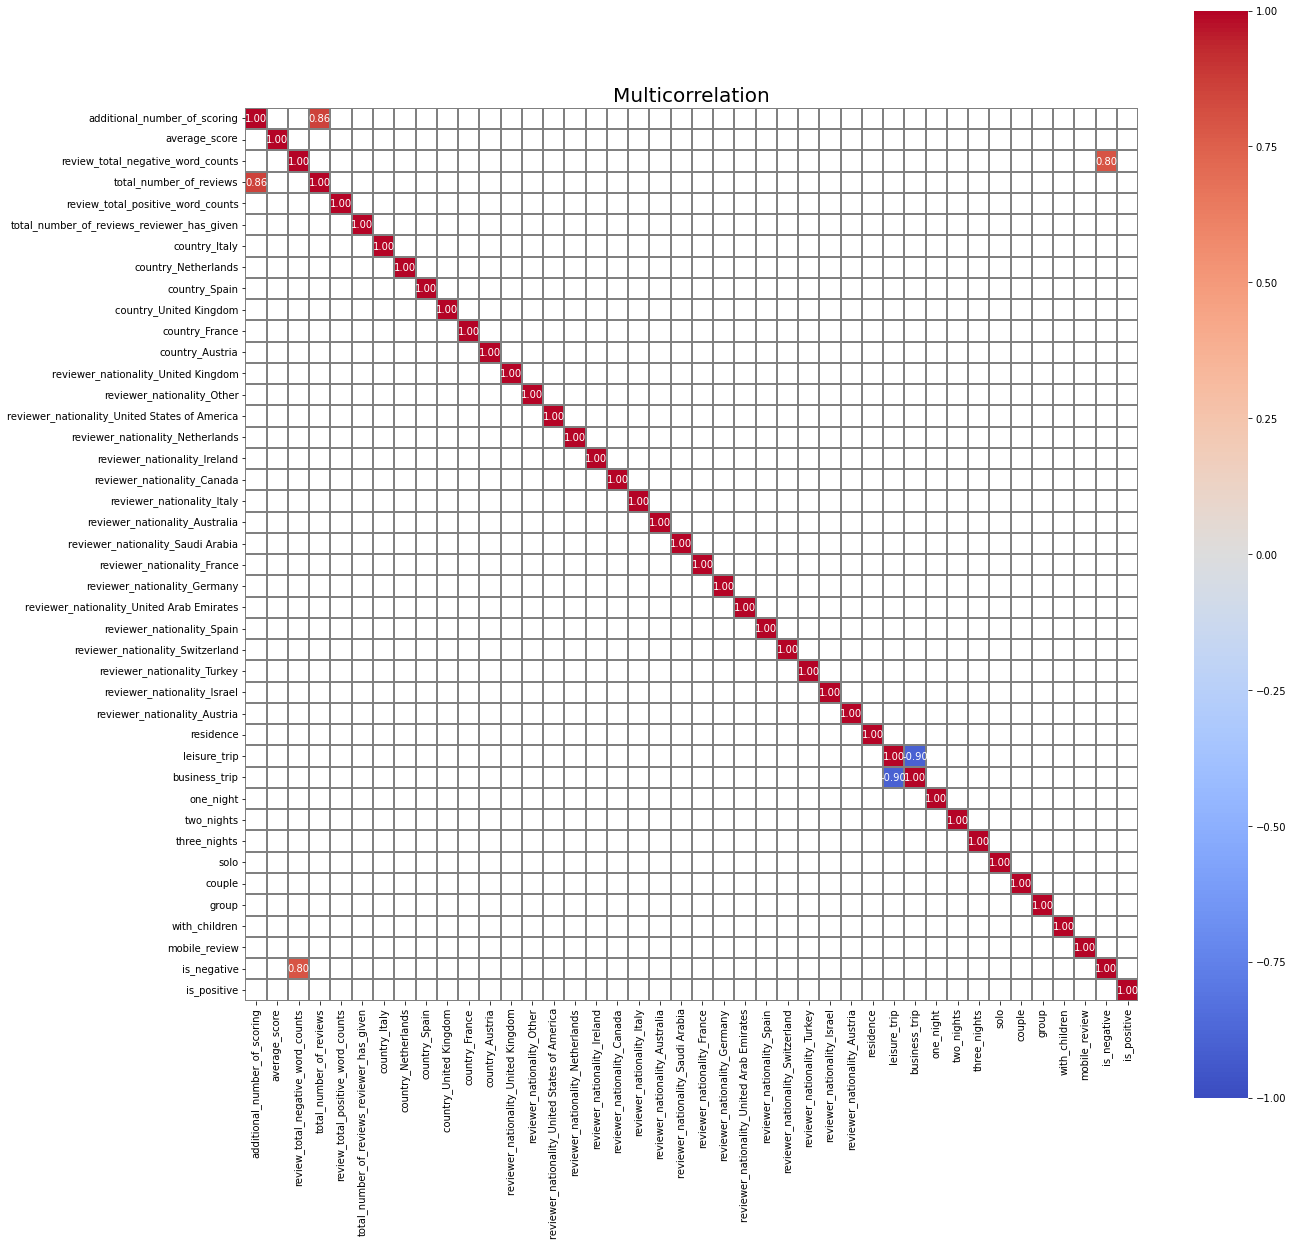

In [64]:
# Строим тепловую корреляционную матрицу для анализа мультиколлинеарности
# используем метод Спирмана, т.к. у нас не только непрерывные переменные
# To perform multicollinearity analysis, make heat correlation map 
# we use the Spearman method, because we have not only continuous variables

# данные для построения графика/data for the heatmap
corr = data.drop(['sample', 'reviewer_score'], axis=1).corr(method='spearman')
plt.subplots(figsize=(20, 20))

# выведем только данные с высоким уровнем корреляции/display only high correlation data
mask_1 = np.abs(corr) >= 0.7
mask_2 = np.abs(corr) <= -0.7
corr_data = corr[mask_1 | mask_2]

# тепловая матрица/heatmap
figure_2 = sns.heatmap(
    corr_data, 
    vmin=-1, 
    vmax=1, 
    linewidth=0.1, 
    linecolor='gray', 
    cmap='coolwarm',
    annot = True,
    fmt='.2f',
    square=True
)

# задаём заголовок/heatmap title
figure_2.set_title('Multicorrelation', fontsize=20)


В соответствии с данными тепловой карты наибольший уровень корреляции у признаков:
1.	Тип поездки отдых (Leisure trip) и командировка (Business_trip) – 0,9;
2.	Общее количество действительных отзывов об отеле (Total number of reviews) и оценки без отзывов (Additional number of scoring) – 0,86;
3.	Отрицательный отзыв (Is negative) и общее количество слов в отрицательном отзыве (Review total negative word counts) – 0, 80.

Для обучения модели создадим 4 дата сета
1.	data – датасет # 0 со всеми признаками;
2.	data_cor_1_f – датасет # 1 без 1 признака с наибольшей корреляцией (Деловая поездка);
3.	data_cor_2_f – датасет # 2 без 2 признаков с высоким уровнем корреляции (Деловая поездка, Additional number of scoring);
4.	data_cor_3_f – датасет # 3 без 3 признаков с высоким уровнем корреляции (Деловая поездка, Additional number of scoring, Review total negative word counts).

Проведем обучение модели на разных датасетах, и посмотрим, какая модель будет обеспечивать наиболее точный результат. 

According to the correlation heatmap the highest correlation score have:
1.	trip type: leisure trip, business trip – 0,9;
2.	total number of reviews and additional number of scoring – 0,86;
3.	is_negativeand review total negative word counts – 0, 80.

To train the model we make 4 datasets:
1.	data – dataset # 0 with all features;
2.	data_cor_1_f – dataset # 1 without 1 feature with the highest correlation score (business trip);
3.	data_cor_2_f – dataset # 2 without 2 features with the highest correlation score (business trip, additional number of scoring);
4.	data_cor_3_f – dataset # 3 without 3 features with the highest correlation score (business trip, additional number of scoring, review total negative word counts).
Train the model on different datasets and see which model will provide the most accurate result.

In [45]:
# удаляем признаки с высоким уровнем коррекляции/dealete features with high correlation score
# датасет # 1 /dataset # 1
data_cor_1_f = data.drop(['business_trip'], axis=1)
# датасет # 2 /dataset # 2
data_cor_2_f = data.drop(['business_trip', 'additional_number_of_scoring'], axis=1)
# датасет # 3/dataset # 3
data_cor_3_f = data.drop(['business_trip', 'additional_number_of_scoring', 'review_total_negative_word_counts'], axis=1)

In [46]:
print(f'Текущее получившееся количество признаков в dataset # 0/Current number of features in dataset # 0: {len(data.columns)}')
print(f'Текущее получившееся количество признаков в dataset # 1/Current number of features in dataset # 1: {len(data_cor_1_f.columns)}')
print(f'Текущее получившееся количество признаков в dataset # 2/Current number of features in dataset # 2: {len(data_cor_2_f.columns)}')
print(f'Текущее получившееся количество признаков в dataset # 3/Current number of features in dataset # 3: {len(data_cor_3_f.columns)}')

Текущее получившееся количество признаков в dataset # 0/Current number of features in dataset # 0: 45
Текущее получившееся количество признаков в dataset # 1/Current number of features in dataset # 1: 44
Текущее получившееся количество признаков в dataset # 2/Current number of features in dataset # 2: 43
Текущее получившееся количество признаков в dataset # 3/Current number of features in dataset # 3: 42


**4. Обучение модели и получение предсказания (Training the model and getting prediction)**

In [47]:
# Выделим тестовую часть в датасетах/Select test part in datasets

# датасет # 0/dataset # 0
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values            # таргет/target
X = train_data.drop(['reviewer_score'], axis=1)

# датасет # 1/dataset # 1
train_data_cor_1_f = data_cor_1_f.query('sample == 1').drop(['sample'], axis=1)
test_data_cor_1_f = data_cor_1_f.query('sample == 0').drop(['sample'], axis=1)

y_1 = train_data_cor_1_f.reviewer_score.values         
X_1 = train_data_cor_1_f.drop(['reviewer_score'], axis=1)

# датасет # 2/dataste # 2
train_data_cor_2_f = data_cor_2_f.query('sample == 1').drop(['sample'], axis=1)
test_data_cor_2_f = data_cor_2_f.query('sample == 0').drop(['sample'], axis=1)

y_2 = train_data_cor_2_f.reviewer_score.values            
X_2 = train_data_cor_2_f.drop(['reviewer_score'], axis=1)

# датасет # 3/dataste # 3
train_data_cor_3_f = data_cor_3_f.query('sample == 1').drop(['sample'], axis=1)
test_data_cor_3_f = data_cor_3_f.query('sample == 0').drop(['sample'], axis=1)

y_3 = train_data_cor_3_f.reviewer_score.values        
X_3= train_data_cor_3_f.drop(['reviewer_score'], axis=1)

In [48]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
# We use the special function train_test_split to split the test data
# select 20% of the data for validation (parameter test_size)

#датасет # 0/dataset # 0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# датасет # 1/dataset # 1
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.2, random_state=RANDOM_SEED)

# датасет # 2/dataset # 2
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=RANDOM_SEED)

# датасет # 3/dataset # 3
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y_3, test_size=0.2, random_state=RANDOM_SEED)

In [49]:
# проверяем датасет # 0/check dataset # 0
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((128935, 44), (381135, 44), (381135, 43), (304908, 43), (76227, 43))

In [50]:
# проверяем датасет # 1/check dataset # 1
test_data_cor_1_f.shape, train_data_cor_1_f.shape, X_1.shape, X_train_1.shape, X_test_1.shape

((128935, 43), (381135, 43), (381135, 42), (304908, 42), (76227, 42))

In [53]:
# проверяем датасет # 2/check dataset # 2
test_data_cor_2_f.shape, train_data_cor_2_f.shape, X_2.shape, X_train_2.shape, X_test_2.shape

((128935, 42), (381135, 42), (381135, 41), (304908, 41), (76227, 41))

In [52]:
# проверяем датасет # 3/check dataset # 3
test_data_cor_3_f.shape, train_data_cor_3_f.shape, X_3.shape, X_train_3.shape, X_test_3.shape

((128935, 41), (381135, 41), (381135, 40), (304908, 40), (76227, 40))

In [54]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [55]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [62]:
# Обучаем модель на тестовом наборе данных # 0/Train the model on the test dataset # 0
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
# Use the trained model to predict the rating of hotels in the test set.
# The predicted values are written to the variable y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    9.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   16.3s finished


In [57]:
# датасет # 1/dataset # 1
model.fit(X_train_1, y_train_1)
y_pred_1 = model.predict(X_test_1)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.4min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    3.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   10.1s finished


In [58]:
# датасет # 2/dataset # 2
model.fit(X_train_2, y_train_2)
y_pred_2 = model.predict(X_test_2)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.9min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   16.8s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   28.5s finished


In [59]:
# датасет # 3/dataset # 3
model.fit(X_train_3, y_train_3)
y_pred_3 = model.predict(X_test_3)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.5min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   10.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   15.4s finished


In [60]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
# Compare the predicted values (y_pred) with the real ones (y_test), and see how they differ on average
# The metric is called Mean Absolute Error (MAE) and shows the average deviation of the predicted values from the actual ones.
print('MAPE dataset # 0:', metrics.mean_absolute_error(y_test, y_pred))
print('MAPE dataset # 1:', metrics.mean_absolute_error(y_test_1, y_pred_1))
print('MAPE dataset # 2:', metrics.mean_absolute_error(y_test_2, y_pred_2))
print('MAPE dataset # 3:', metrics.mean_absolute_error(y_test_3, y_pred_3))

MAPE dataset # 0: 0.9223275445354214
MAPE dataset # 1: 0.9226271450654592
MAPE dataset # 2: 0.9233992764874587
MAPE dataset # 3: 1.0188136114035098


Наиболее точный результат (наименьшее отклонение) у датасета #0, со всеми признаками, без удаления признаков с высоким уровнем корреляции. На его примере определим признаки, наиболее важные для модели.
 
The most accurate result has dataset #0, with all features, without removing features with a high level of correlation. On its example, we will determine the features that are most important for the model.

<AxesSubplot: >

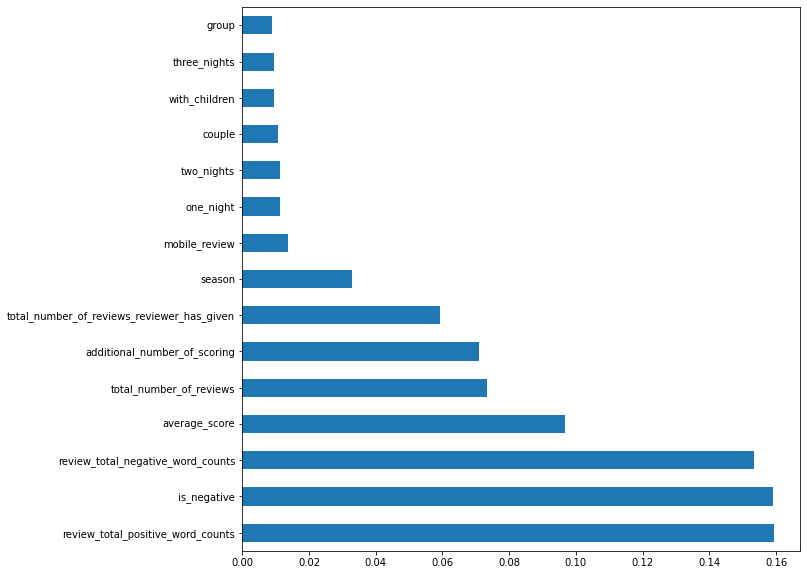

In [63]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
# RandomForestRegressor gives us an opportunity to display the most important features of the model

plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [64]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,country_Italy,country_Netherlands,country_Spain,...,one_night,two_nights,three_nights,solo,couple,group,with_children,mobile_review,is_negative,is_positive
16021,1485,7.5,22,6977,3,11,0.0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
54254,227,8.6,0,968,21,1,0.0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
3563,474,8.2,27,3568,8,10,0.0,0,1,0,...,0,0,1,0,0,1,0,0,1,1
42939,185,8.0,9,3333,4,8,0.0,0,0,0,...,0,1,0,0,1,0,0,1,1,1
102620,514,8.9,43,7108,101,17,0.0,0,1,0,...,0,1,0,0,1,0,0,0,1,1
98248,704,8.3,14,2443,6,33,0.0,0,0,0,...,1,0,0,1,0,0,0,0,1,1
125436,107,9.5,4,385,10,3,0.0,0,0,0,...,1,0,0,0,1,0,0,1,1,1
80151,321,8.6,174,3557,3,7,0.0,0,0,0,...,0,1,0,0,1,0,0,0,1,1
46181,309,8.1,10,2270,24,2,0.0,0,1,0,...,0,0,0,0,1,0,0,0,1,1
53111,834,9.1,8,4687,5,1,0.0,0,1,0,...,0,1,0,0,0,1,0,0,1,1


In [65]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [66]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [67]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   15.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   26.1s finished


In [68]:
predict_submission

array([8.515, 7.123, 8.36 , ..., 7.487, 9.492, 6.683])

In [69]:
list(sample_submission)

['reviewer_score', 'id']

In [70]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,reviewer_score,id
0,8.515,488440
1,7.123,274649
2,8.360,374688
3,9.759,404352
4,9.517,451596
5,8.722,302161
6,7.189,317079
7,7.779,13963
8,8.550,159785
9,7.992,195089
